<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hard-coded-agents-championship" data-toc-modified-id="Hard-coded-agents-championship-1">Hard coded agents championship</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Agents" data-toc-modified-id="Agents-1.2">Agents</a></span><ul class="toc-item"><li><span><a href="#Random" data-toc-modified-id="Random-1.2.1">Random</a></span></li><li><span><a href="#Random-plus" data-toc-modified-id="Random-plus-1.2.2">Random plus</a></span></li><li><span><a href="#Greedy" data-toc-modified-id="Greedy-1.2.3">Greedy</a></span></li><li><span><a href="#Risk-averse-goose" data-toc-modified-id="Risk-averse-goose-1.2.4">Risk averse goose</a></span></li><li><span><a href="#Simple-BFS" data-toc-modified-id="Simple-BFS-1.2.5">Simple BFS</a></span></li><li><span><a href="#Straightforward" data-toc-modified-id="Straightforward-1.2.6">Straightforward</a></span></li><li><span><a href="#boilergoose" data-toc-modified-id="boilergoose-1.2.7">boilergoose</a></span></li></ul></li><li><span><a href="#Championship" data-toc-modified-id="Championship-1.3">Championship</a></span><ul class="toc-item"><li><span><a href="#Code" data-toc-modified-id="Code-1.3.1">Code</a></span></li><li><span><a href="#Elo-ranking" data-toc-modified-id="Elo-ranking-1.3.2">Elo ranking</a></span></li><li><span><a href="#Finding-the-optimal-speed-factor-K-for-Elo-ranking" data-toc-modified-id="Finding-the-optimal-speed-factor-K-for-Elo-ranking-1.3.3">Finding the optimal speed factor K for Elo ranking</a></span></li><li><span><a href="#Paralellize-matches" data-toc-modified-id="Paralellize-matches-1.3.4">Paralellize matches</a></span></li><li><span><a href="#Matches" data-toc-modified-id="Matches-1.3.5">Matches</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.4">Summary</a></span></li></ul></li></ul></div>

# Hard coded agents championship

## Imports

In [1]:
import os
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor
import time

%config Completer.use_jedi = False

Loading environment football failed: No module named 'gfootball'


In [2]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Agents

### Random

https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/hungry_geese/hungry_geese.py#L117

```python
def random_agent():
    return choice([action for action in Action]).name
```

### Random plus

This is a random bot but does not make opposite actions.

In [3]:
class RandomPlus:
    def __init__(self):
        self.last_action = None
        
    def __call__(self):
        if self.last_action is not None:
            options = [action for action in Action if action != self.last_action.opposite()]
        else:
            options = [action for action in Action if action]
            
        action = random.choice(options)
        self.last_action = action
        return action.name

In [4]:
cached_random_plus_agents = {}

In [5]:
def random_plus_agent(obs, config):
    index = obs["index"]
    if index not in cached_random_plus_agents:
        cached_random_plus_agents[index] = RandomPlus()
    return cached_random_plus_agents[index]()

### Greedy

https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/hungry_geese/hungry_geese.py#L121

- Don't move adjacent to any heads
- Don't move into any bodies
- Move to the closest food

```python
class GreedyAgent:
    def __init__(self, configuration: Configuration):
        self.configuration = configuration
        self.last_action = None

    def __call__(self, observation: Observation):
        rows, columns = self.configuration.rows, self.configuration.columns

        food = observation.food
        geese = observation.geese
        opponents = [
            goose
            for index, goose in enumerate(geese)
            if index != observation.index and len(goose) > 0
        ]

        # Don't move adjacent to any heads
        head_adjacent_positions = {
            opponent_head_adjacent
            for opponent in opponents
            for opponent_head in [opponent[0]]
            for opponent_head_adjacent in adjacent_positions(opponent_head, columns, rows)
        }
        # Don't move into any bodies
        bodies = {position for goose in geese for position in goose}

        # Move to the closest food
        position = geese[observation.index][0]
        actions = {
            action: min_distance(new_position, food, columns)
            for action in Action
            for new_position in [translate(position, action, columns, rows)]
            if (
                new_position not in head_adjacent_positions and
                new_position not in bodies and
                (self.last_action is None or action != self.last_action.opposite())
            )
        }

        action = min(actions, key=actions.get) if any(actions) else choice([action for action in Action])
        self.last_action = action
        return action.name
```

### Risk averse goose

https://www.kaggle.com/ilialar/risk-averse-greedy-goose

This notebook proposes a simple greedy straightforward solution. At each step:
- Mark all cells that can be dangerous on the next step as obstacles
- Find the shortest route to the nearest food item
- Make one step toward this food
- Repeat

### Simple BFS

https://www.kaggle.com/aatiffraz/simple-bfs-starter-agent

- Obstacle-ize your opponents
- Obstacle-ize your body, except the last part
- Count food only if there's no chance an opponent will meet you there

It is outdated because it does not check last direction.

### Straightforward

It is not explained.

### boilergoose

> This is a structure for a flood-fill based algorithm. I think it may be developed into something useful. With this structure it should be easy to prevent the Goose from dying in dead end, but this is left as an exercise for the reader 😀

## Championship

### Code

In [6]:
def sample_agent_keys(agents):
    if isinstance(agents, dict):
        keys = list(agents.keys())
    else:
        keys = agents
    while 1:
        samples = np.random.choice(keys, size=4)
        if len(np.unique(samples)) > 1:
            break
    return samples

### Elo ranking

In [7]:
class EloRanking():
    def __init__(self, agents, k=8, verbose=False):
        """
        Computes Elo ranking
        
        Parameters
        -----------
        agents : list of str
            Name of the agents that will be used in the ranking
        k : float
            Elo speed constant, it seems that 8 is ok for our problem
        verbose : bool
        """
        self.ranking = {agent: [1000] for agent in agents}
        self.k = k
        self.verbose = verbose
    
    def add_match(self, agents, scores):
        updates = self._compute_updates(agents, scores)
        if self.verbose: print(updates)
        self._apply_updates(updates)
        
    def _compute_updates(self, agents, scores):
        updates = {agent:0 for agent in np.unique(agents)}
        for idx, agent1 in enumerate(agents):
            score1 = scores[idx]
            for agent2, score2 in zip(agents[idx+1:], scores[idx+1:]):
                if agent1 == agent2:
                    continue
                result = elo_result(score1, score2)
                update = self.k*(result - elo_expectation(self.ranking[agent1][-1], self.ranking[agent2][-1]))
                updates[agent1] += update
                updates[agent2] -= update
                self.verbose: print(agent1, score1, agent2, score2, elo_result(score1, score2))
        return updates
    
    def _apply_updates(self, updates):
        for agent in self.ranking:
            if agent in updates:
                self.ranking[agent].append(self.ranking[agent][-1] + updates[agent])
            else:
                self.ranking[agent].append(self.ranking[agent][-1])
                
    def plot(self):
        for agent, ranking in self.ranking.items():
            #plt.plot(ranking, label=agent, marker='o')
            plt.plot(ranking, label=agent)
        plt.legend(loc=0)
        plt.grid(axis='y')
        
    def summary(self):
        agents = list(self.ranking.keys())
        ranking = [int(self.ranking[agent][-1]) for agent in agents]
        summary = pd.DataFrame(dict(ranking=ranking), index=agents)
        return summary.sort_values('ranking', ascending=False)
        
                
def elo_result(score1, score2):
    if score1 > score2:
        return 1
    elif score1 == score2:
        return 0.5
    else:
        return 0
    
def elo_expectation(ranking1, ranking2):
    return 1./(1+10**((ranking2 - ranking1)/400))

### Finding the optimal speed factor K for Elo ranking

In [46]:
sampled_keys = ['random', 'random', 'random_plus', 'random_plus']

rets = evaluate("hungry_geese", agents=[agents[key] for key in sampled_keys], num_episodes=1000)

On chess the recommend value for k is 32. However we can see below that the metrics are very noisy if using that value.
However smaller k is used for players with higher level. 

https://en.wikipedia.org/wiki/Elo_rating_system

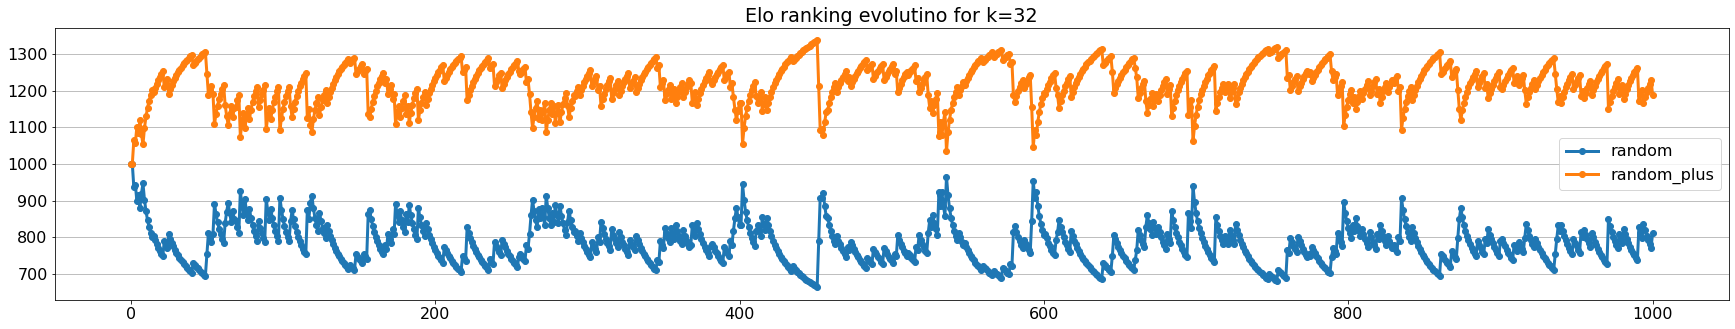

In [66]:
k = 32
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

In the other hand if we use k=1 we get very stable scores, but it takes more than 600 matches to reach an equilibrium with a difference of around 400 points between agents. Let's see if we can get faster
convergence without too much noise.

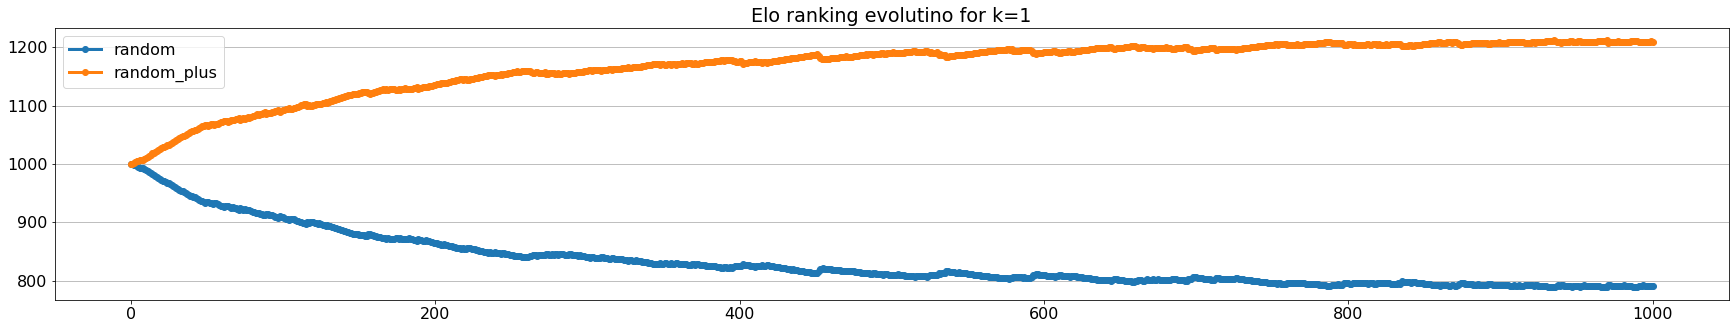

In [68]:
k = 1
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

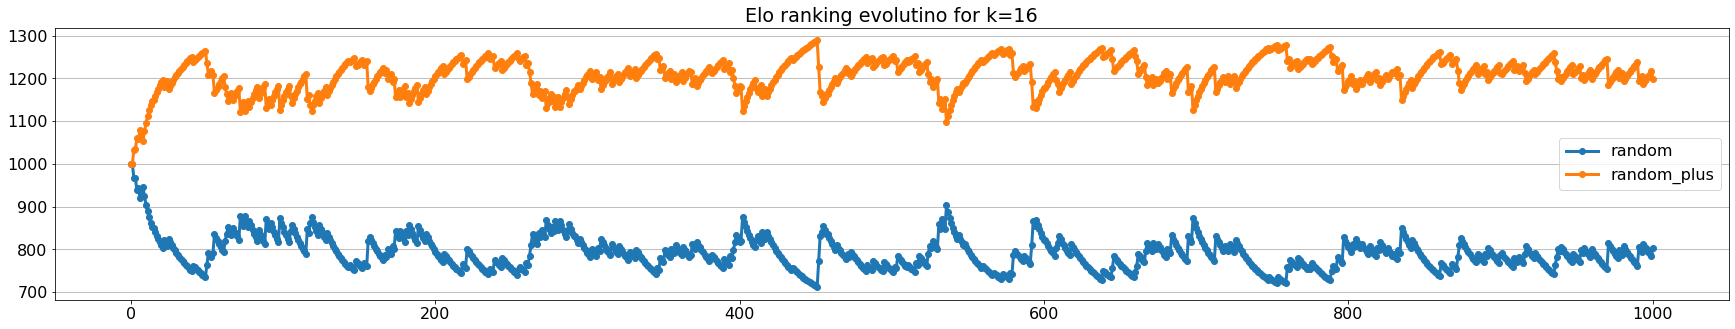

In [65]:
k = 16
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

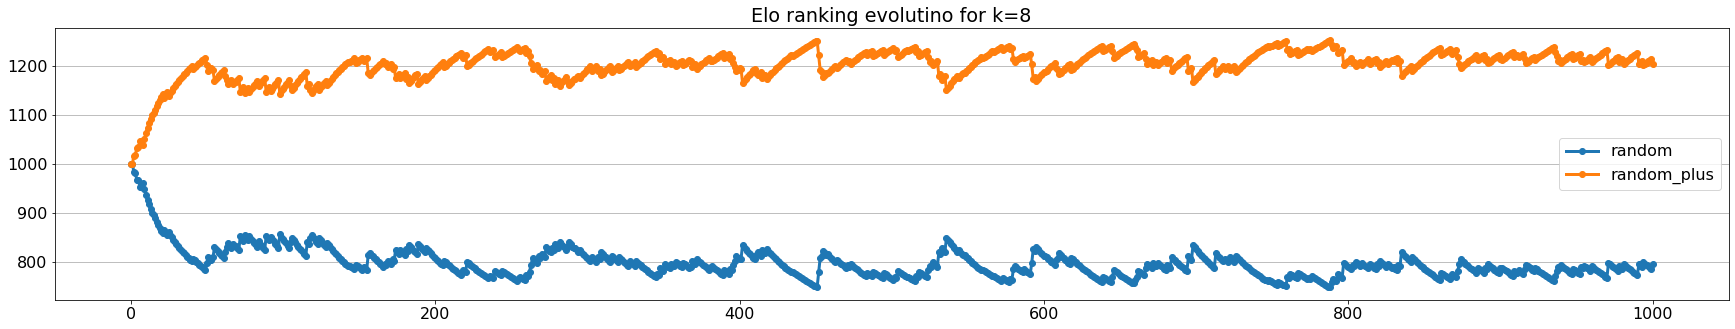

In [64]:
k = 8
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

8 might be a good compromise value, it seems to reach convergence around 50 matches and it is not very noisy. K=4 seems to be very slow.

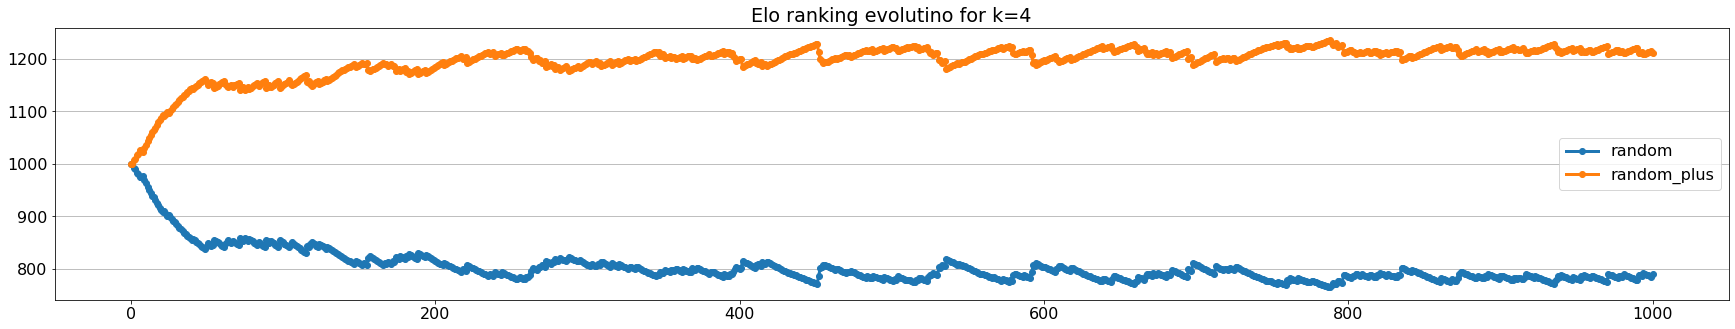

In [63]:
k = 4
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

### Paralellize matches

Cpu utilization is very low, let's try to parallelize matches.

In [8]:
def play_game(sampled_keys):
    return evaluate("hungry_geese", agents=[agents[key] for key in sampled_keys], num_episodes=1)


In [9]:
def monitor_progress(submits, verbose=True):
    progress_bar = tqdm(total=len(submits))
    progress = 0
    while 1:
        time.sleep(1)
        current_progress = np.sum([submit.done() for submit in submits])
        if current_progress > progress:
            if verbose:
                progress_bar.update(current_progress - progress)
            progress = current_progress
        if progress == len(submits):
            break
    time.sleep(0.1)

In [10]:
def play_matches_in_parallel(agents, max_workers=20, n_matches=1000):
    pool = ProcessPoolExecutor(max_workers=max_workers)
    matches_results = []
    matches_agents = []
    submits = []
    for i in range(n_matches):
        sampled_keys = sample_agent_keys(agents)
        submits.append(pool.submit(play_game, sampled_keys))
        matches_agents.append(sampled_keys)
    monitor_progress(submits)
    
    matches_results = [submit.result()[0] for submit in submits]
    return matches_agents, matches_results

### Matches

In [11]:
agents = {
    'random': 'random',
    'random_plus': random_plus_agent,
    'greedy': 'greedy',
    'risk_averse_goose': '../forum/agents/risk_averse_goose.py',
    'goose_on_a_healthy_diet': '../forum/agents/goose_on_a_healthy_diet.py',
    #'simple_bfs': '../forum/agents/simple_bfs.py', #outdated because it does not check if it is reverting the direction
    'straightforward_bfs': '../forum/agents/straightforward_bfs.py',
    'boilergoose': '../forum/agents/boilergoose.py',
    'crazy_goose': '../forum/agents/crazy_goose.py',
    'besthoarder': '../forum/agents/besthoarder.py',
    'greedyhoarder': '../forum/agents/greedyhoarder.py',
    #'risk_averse_greedy': '../forum/agents/risk_averse_greedy.py', #outdated because it does not check if it is reverting the direction
}

In [12]:
matches_agents, matches_results = play_matches_in_parallel(agents, max_workers=20, n_matches=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

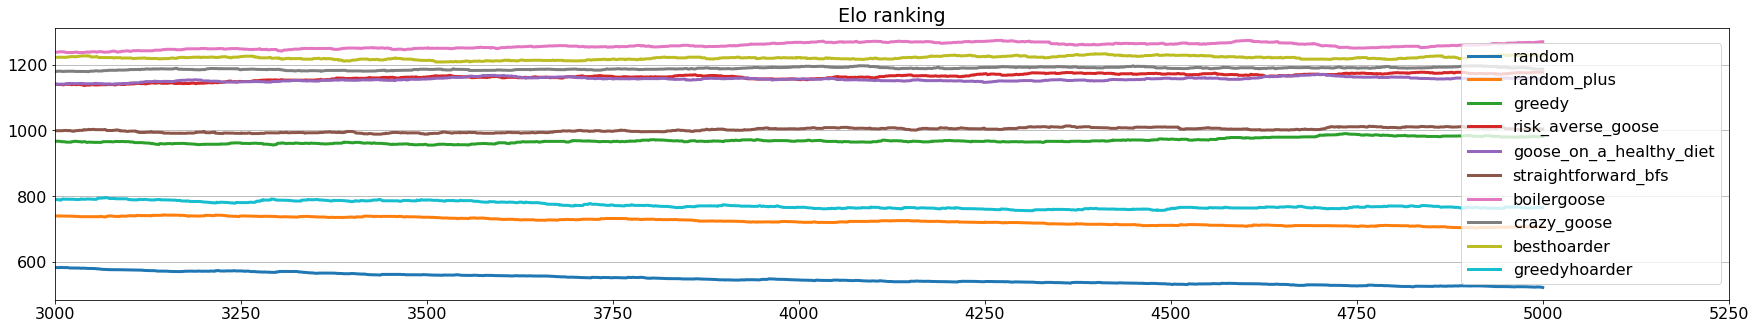

,ranking
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766
random_plus,706
random,523


In [13]:
elo_ranking = EloRanking(list(agents.keys()), k=1)
for match_agents, match_results in zip(matches_agents, matches_results):
    elo_ranking.add_match(match_agents, match_results)
elo_ranking.plot()
plt.xlim(left=3000)
plt.title('Elo ranking'); plt.show();
elo_ranking.summary()

So this is very interesting, we have compared many hard-coded agents and see that there are much stronger agents than greedy. For example boilergoose will beat greedy agent 83% of the times.

This gives us a very good start point to train reinforcement learning agents. We should aim to create a first RL agent that scores around 1500. Then aim to 1700, 1900... and create a ladder of improving agents.

In [14]:
elo_expectation(1269, 981)

0.8399506946347535

In [18]:
[round(elo_expectation(score, 1000), 2) for score in [1100, 1200, 1300, 1400, 1500]]

[0.64, 0.76, 0.85, 0.91, 0.95]

Could parallelization affect some of the agents?

I don't think so, if it did we would see much lower scores due to not remembering the last action.

In [21]:
summary = elo_ranking.summary()
summary.index.name = 'model'
summary.to_csv('../data/elo_ranking.csv')

## Summary

- We have reviewed many hard-coded agents from the forum
- We have implemented an elo ranking
- We have found the ranking for each agent